In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.constants import R_earth
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from pandoravisibility import Visibility

from astropy.visualization import time_support

In [2]:
# this is a draft TLE we can use

# be careful to use the most up to date one!
               
line1 = "1 99152U 25037A   25288.00000000 .000000000  00000+0  00000-0 0   426"
line2 = "2 99152  97.8636 275.2378 0000010   0.0103   0.0000 14.89338871  1234"
              

In [3]:
vis = Visibility(line1, line2)


### run the simulation from Oct 2025 to November 2026

In [4]:
# Define start and stop times
tstart = Time("2025-10-15T00:00:00.000")
tstop = Time("2026-11-15T00:00:00.000")  # Example stop time

# Calculate times with a step of 10 minute
deltas = np.arange(0, (tstop - tstart).to_value(u.min), 10) * u.min
times = tstart + TimeDelta(deltas)


# Use these times with your Visibility module
state = vis.get_state(times)

In [5]:
# let's look at AU Mic for example

target_coord = SkyCoord(311.2897187392163, -31.3408994138447, frame="icrs", unit="deg")
targ_vis = vis.get_visibility(target_coord, times)

In [6]:
moon_vis = vis.get_constraint(target_coord, "moon", times)
sun_vis = vis.get_constraint(target_coord, "sun", times)
earthlimb_vis = vis.get_constraint(target_coord, "earthlimb", times)

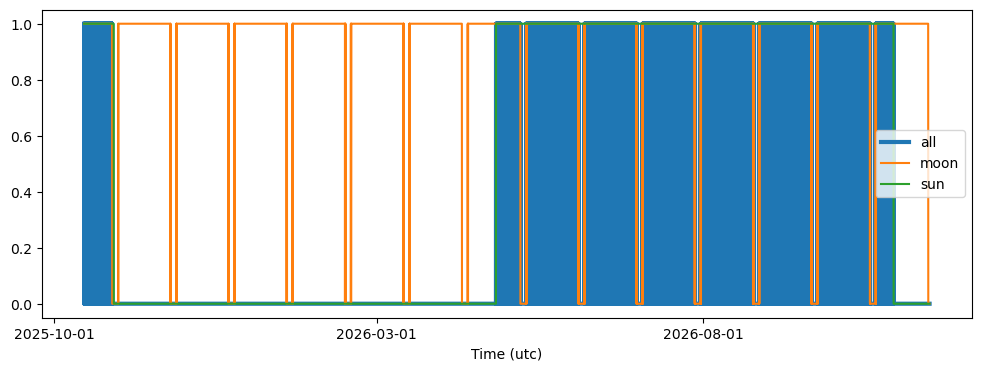

In [7]:
# we can ask this to show us all the visibility constrains, or just the sun, earth or moon

with time_support():
    plt.figure(figsize=[12,4])
    plt.plot(times.utc, targ_vis, color="C0", label="all", lw=3, zorder=0)
    plt.plot(times.utc, moon_vis, label="moon", color="C1", )
    plt.plot(times.utc, sun_vis, label="sun", color="C2", )
    
    plt.legend()

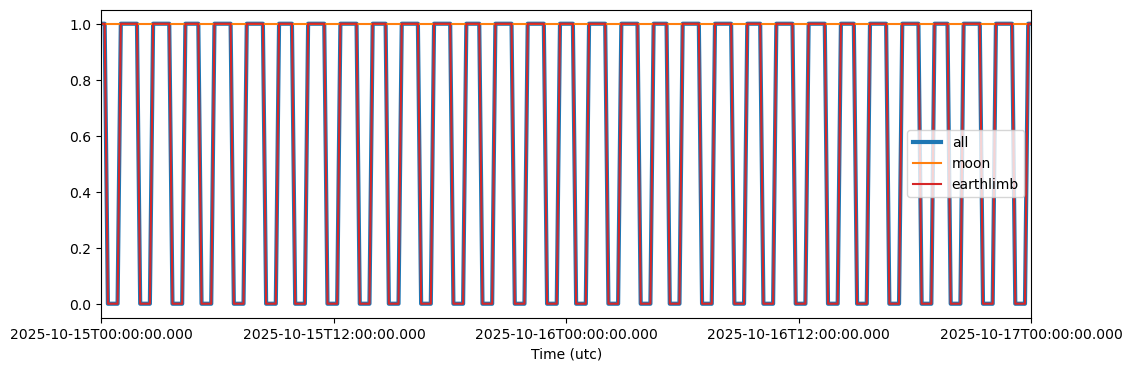

In [8]:
# similar but on a smaller time window

with time_support():
    plt.figure(figsize=[12,4])
    plt.plot(times.utc, targ_vis, color="C0", label="all", lw=3, zorder=0)
    plt.plot(times.utc, moon_vis, label="moon", color="C1", )
    plt.plot(times.utc, earthlimb_vis, label="earthlimb", color="C3", )
    
    plt.xlim(times.utc.min(), times.utc.min() + 2 * u.d)
    
    plt.legend()

## we are going to now move from the minute-by-minute to looking at daily averages

In [9]:
# let's calculate the average visibility over a given day

data_numeric = targ_vis.astype(int)

# Define the window size
window_size = 144

# Calculate the running average in steps of the window size
num_windows = len(data_numeric) // window_size
running_average = [
    np.mean(data_numeric[i * window_size : (i + 1) * window_size])
    for i in range(num_windows)
]

running_average = np.array(running_average)

<Figure size 700x400 with 0 Axes>

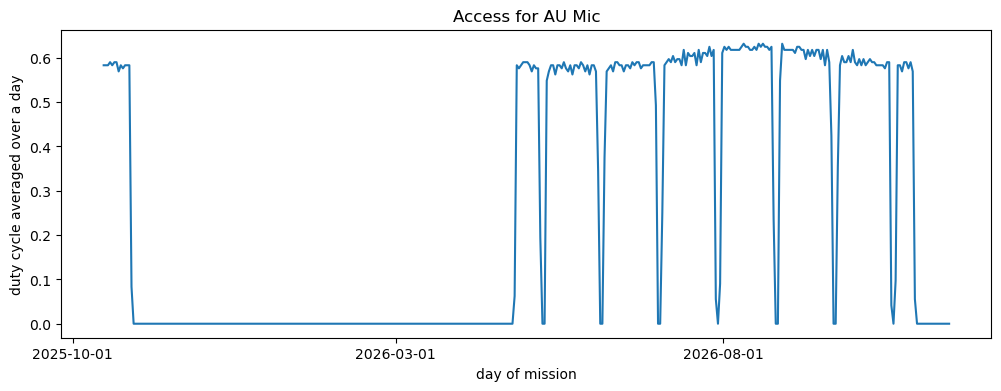

In [11]:
with time_support():
    plt.figure(figsize=[7, 4])

    tms = tstart + TimeDelta(np.arange(0.5, (tstop - tstart).jd, 1) * u.day)

    plt.figure(figsize=[12, 4])
    plt.plot(tms, running_average)
    plt.xlabel("day of mission")
    plt.ylabel("duty cycle averaged over a day")
    plt.title("Access for AU Mic")


## ok, now lets look at all the Pandora targets. this is a target list that is old but gives an idea

In [12]:
targets = [
    ["WASP-69", "b", 315.026, -5.09486],
    ["WASP-107", "b", 188.386, -10.1462],
    ["HIP 65 A", "b", 0.185606, -54.8308],
    ["TOI-3884", "b", 181.572, 12.507],
    ["GJ 1214", "b", 258.831, 4.96068],
    ["WASP-177", "b", 334.797, -1.83443],
    ["WASP-80", "b", 303.167, -2.14444],
    ["WASP-52", "b", 348.495, 8.76108],
    ["TOI-942", "b", 76.6496, -20.2456],
    ["K2-198", "b", 198.844, -6.46499],
    ["L 98-59", "d", 124.533, -68.3145],
    ["TOI-2427", "b", 52.2917, -31.3629],
    ["TOI-1685", "b", 68.594, 43.037],
    ["TOI-836", "b", 225.08, -24.4542],
    ["TOI-1416", "b", 216.923, 41.953],
    ["HD 3167", "b", 8.74015, 4.38072],
    ["TOI-776", "b", 178.578, -37.5534],
    ["GJ 9827", "b", 351.772, -1.28534],
    ["TOI-244", "b", 10.5698, -36.718],
    ["LTT 1445 A", "c", 45.4625, -16.5945],
]
target_df = pd.DataFrame(targets, columns=["star", "planet", "ra", "dec"])

In [13]:
# let's go through a list of targets and create a visibility for each of them

tv = {}

for i, t in target_df.iterrows():
    target_coord = SkyCoord(t.ra, t.dec, frame="icrs", unit="deg")
    targ_vis = vis.get_visibility(target_coord, times)

    data_numeric = targ_vis.astype(int)
    # Define the window size
    window_size = 144

    # Calculate the running average in steps of the window size
    num_windows = len(data_numeric) // window_size
    running_average = [
        np.mean(data_numeric[i * window_size : (i + 1) * window_size])
        for i in range(num_windows)
    ]

    running_average = np.array(running_average)

    tv[t.star] = running_average

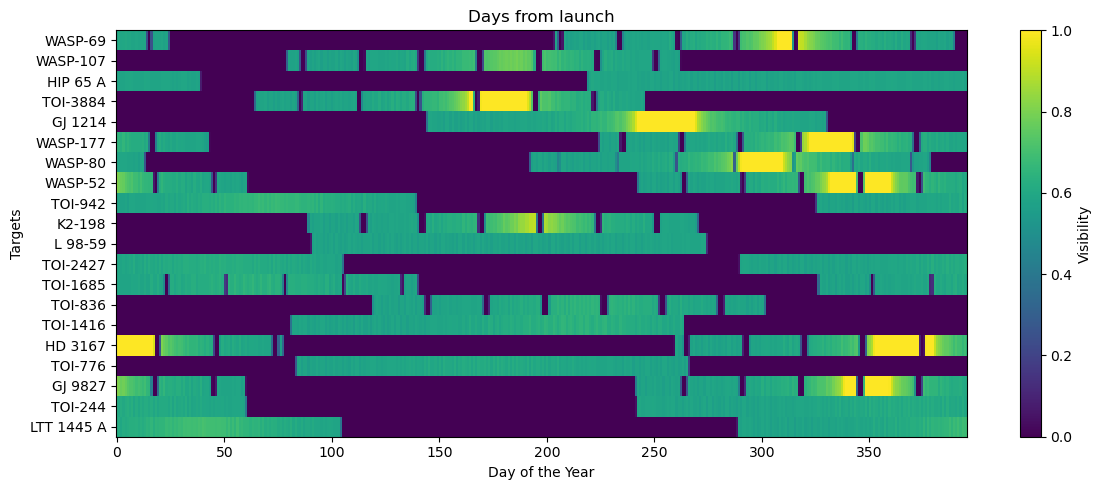

In [14]:
targets = list(tv.keys())
days = np.arange(1, 396 + 1)
visibility_matrix = np.array([tv[target] for target in targets])

fig, ax = plt.subplots(figsize=(12, 5))
cax = ax.imshow(
    visibility_matrix, aspect="auto", cmap="viridis", interpolation="nearest"
)

ax.set_yticks(np.arange(len(targets)))
ax.set_yticklabels(targets)
ax.set_xlabel("Day of the Year")
ax.set_ylabel("Targets")
plt.colorbar(cax, label="Visibility")
plt.title("Days from launch")
plt.tight_layout()
# plt.savefig("pandora-target-visibility.png", dpi=300)

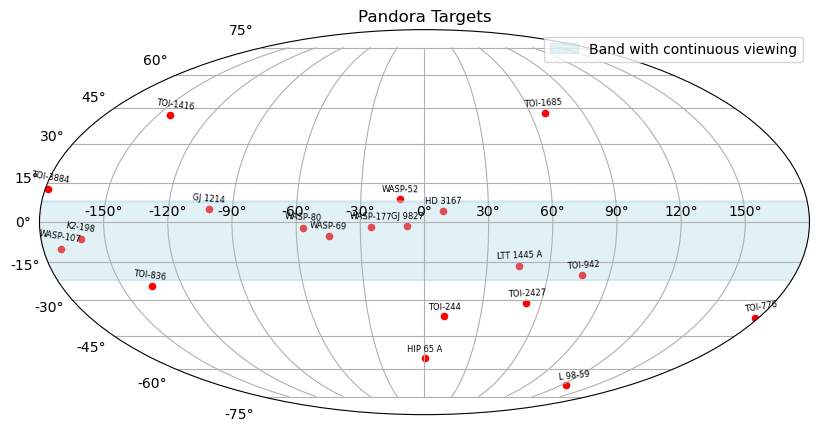

In [34]:
# this attemps to show targets across the sky 

# Convert RA to radians, wrap to [-180, 180] for Mollweide
ra_rad = np.radians(np.remainder(target_df.ra + 180, 360) - 180)
dec_rad = np.radians(target_df.dec)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_rad, dec_rad, s=20, color='red')

# Add band: fill between curves at Dec = -7 ± 15 degrees
# Targets in this region can be observed continuously for 30 days
dec_center = -7
dec_width = 15
ymin = np.radians(dec_center - dec_width)
ymax = np.radians(dec_center + dec_width)

# For fill_between to work, we need x values across the whole RA range
x = np.linspace(-np.pi, np.pi, 1000)
ax.fill_between(x, ymin, ymax, color='lightblue', alpha=0.35, label='Band with continuous viewing')

for ra, dec, name in zip(ra_rad, dec_rad, target_df.star):
    angle = np.degrees(ra)
    ax.text(ra, dec + label_offset, name, fontsize=6,
            rotation=angle / 20, ha='center', va='bottom', color='black')

ax.grid(True)
ax.set_title("Pandora Targets")
ax.legend()

